AirPassengers dataset loaded successfully from the new URL!
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

Training set size: 132
Test set size: 12


16:59:14 - cmdstanpy - INFO - Chain [1] start processing
16:59:14 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



Model training complete.

Model Evaluation (on the last 12 months):
Root Mean Squared Error (RMSE): 41.53


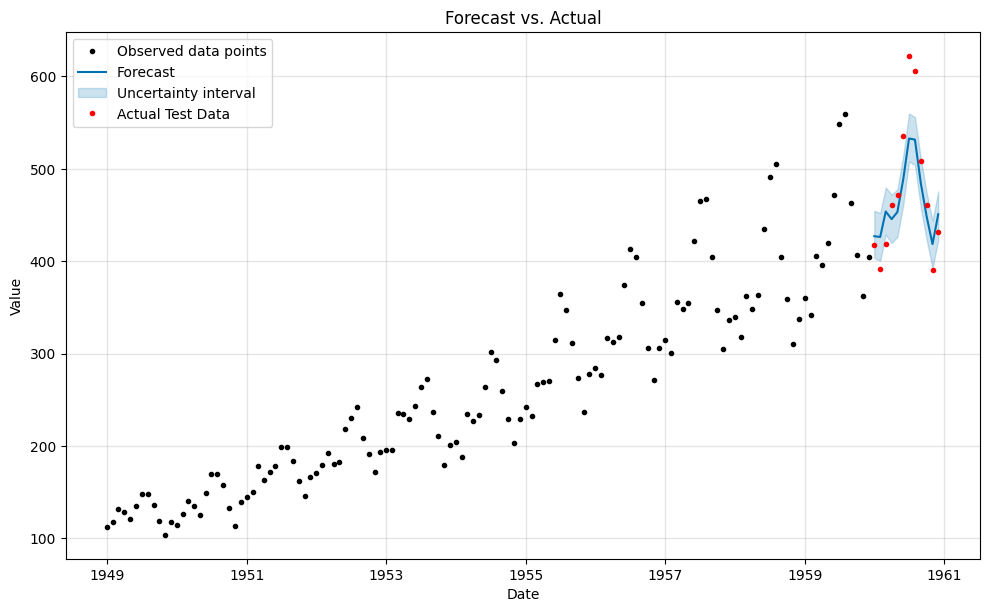


Full model training, forecasting, and evaluation complete.


In [3]:
# --- 1. Import Necessary Libraries ---
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# --- 2. Load the Dataset ---
# Using a new, stable URL from a different repository
try:
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv'
    df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)
    df.index.name = 'Month'
    df.columns = ['Passengers']
    print("AirPassengers dataset loaded successfully from the new URL!")
    print(df.head())
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Exit or handle the error gracefully if the data can't be loaded
    raise SystemExit("Dataset loading failed. Please check the URL and your internet connection.")

# --- 3. Prepare Data for Prophet ---
# Prophet requires the dataframe to have two specific columns:
# 'ds' (datestamp) and 'y' (the value to be forecasted).
df_prophet = df.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})

# --- 4. Split Data into Training and Testing Sets ---
train_size = len(df_prophet) - 12
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

print(f"\nTraining set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# --- 5. Initialize and Train the Prophet Model ---
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
model.fit(train_df)
print("\nModel training complete.")

# --- 6. Make Predictions ---
future = model.make_future_dataframe(periods=12, freq='M', include_history=False)
forecast = model.predict(future)

# --- 7. Evaluate the Model's Performance ---
actual_values = test_df['y'].values
predicted_values = forecast['yhat'].values

rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"\nModel Evaluation (on the last 12 months):")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- 8. Visualize the Results ---
fig = model.plot(forecast)
plt.title("Forecast vs. Actual")
plt.xlabel("Date")
plt.ylabel("Value")
# Plotting the actual test data for comparison
plt.plot(test_df['ds'], actual_values, 'r.', label='Actual Test Data')
plt.legend()
plt.show()

print("\nFull model training, forecasting, and evaluation complete.")

Dataset loaded successfully!

DataFrame shape after feature engineering and dropping NaNs: (130, 12)
Features DataFrame has 11 columns. All looks good!

XGBoost model training complete.

Model Evaluation (on the last 12 months):
Root Mean Squared Error (RMSE): 46.45
Mean absolute Error (MAE): 38.66
Mean Squared Error (MSE): 2157.75


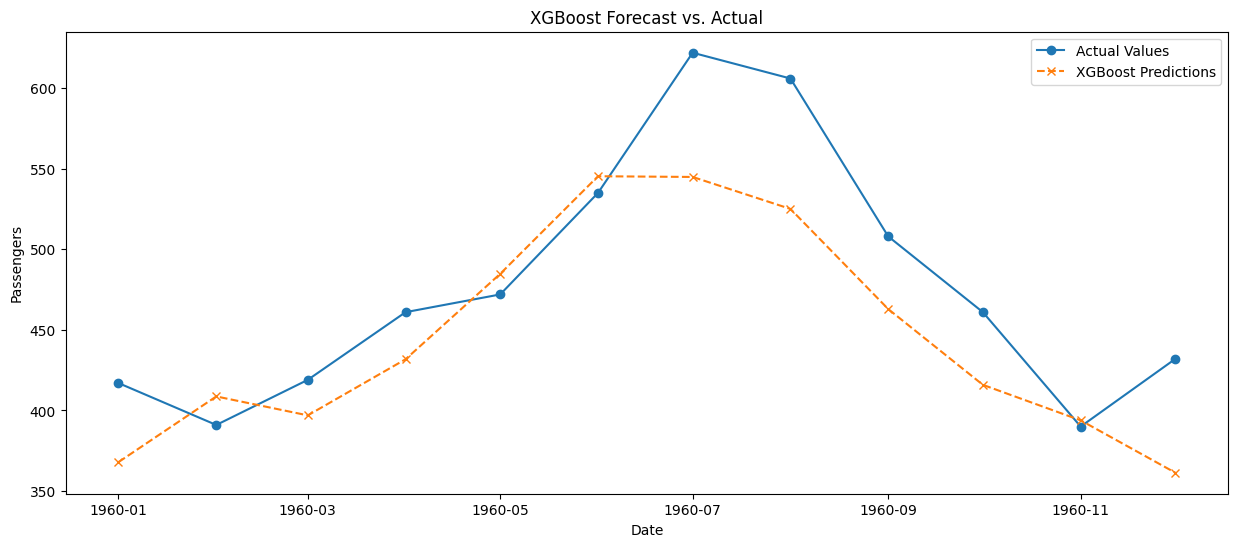

Full XGBoost training, forecasting, and evaluation complete.


In [17]:
# --- All Imports ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Load the Dataset ---
# Correct URL from our previous successful run
try:
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv'
    df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)
    df.index.name = 'Month'
    df.columns = ['Passengers']
    print("Dataset loaded successfully!")
except Exception as e:
    raise SystemExit(f"Error loading dataset: {e}")

# --- 2. Prepare Data for Feature Engineering ---
# Make a copy to avoid modifying the original DataFrame
df_features = df.copy()

# --- 3. Create Time-Based Features (From our previous step) ---
# This is crucial for tree-based models like XGBoost.
df_features['year'] = df_features.index.year
df_features['month'] = df_features.index.month
df_features['week_of_year'] = df_features.index.isocalendar().week.astype(int)
df_features['day_of_year'] = df_features.index.dayofyear
df_features['day_of_week'] = df_features.index.dayofweek
df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)

# --- 4. Create Lag and Rolling Window Features (From our previous step) ---
target_variable = 'Passengers'  # This is the correct target variable
df_features['lag_1'] = df_features[target_variable].shift(1)
df_features['lag_7'] = df_features[target_variable].shift(7)
df_features['lag_14'] = df_features[target_variable].shift(14)
df_features['rolling_mean_7'] = df_features[target_variable].rolling(window=7).mean().shift(1)
df_features['rolling_std_7'] = df_features[target_variable].rolling(window=7).std().shift(1)

# --- 5. Handle Missing Values Created by Lags/Rolling Windows ---
# The first few rows will have NaN values. We must drop them.
df_features = df_features.dropna()
print(f"\nDataFrame shape after feature engineering and dropping NaNs: {df_features.shape}")

# --- 6. Prepare Data for XGBoost ---
# Now we can safely split into X (features) and y (target).
y = df_features[target_variable]
X = df_features.drop(columns=[target_variable])

# Sanity check: Ensure we have columns in X
if X.shape[1] == 0:
    raise ValueError("Features DataFrame is empty. Please check your feature engineering steps.")
print(f"Features DataFrame has {X.shape[1]} columns. All looks good!")

# --- 7. Split Data into Training and Testing Sets ---
test_size_months = 12
train_size = len(df_features) - test_size_months
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# --- 8. Initialize and Train the XGBoost Model ---
model = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    learning_rate=0.05,
    eval_metric='rmse'
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
print("\nXGBoost model training complete.")

# --- 9. Make Predictions and Evaluate ---
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions )
mse = mean_squared_error(y_test, predictions)
print(f"\nModel Evaluation (on the last 12 months):")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

# --- 10. Visualize the Results ---
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual Values', marker='o')
plt.plot(y_test.index, predictions, label='XGBoost Predictions', marker='x', linestyle='--')
plt.title("XGBoost Forecast vs. Actual")
plt.xlabel("Date")
plt.ylabel(target_variable)
plt.legend()
plt.show()

print("Full XGBoost training, forecasting, and evaluation complete.")

In [12]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


/tmp/ipykernel_36/4115617497.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  combined_df['Forecast'].iloc[len(y_train):] = predictions
/tmp/ipykernel_36/4115617497.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

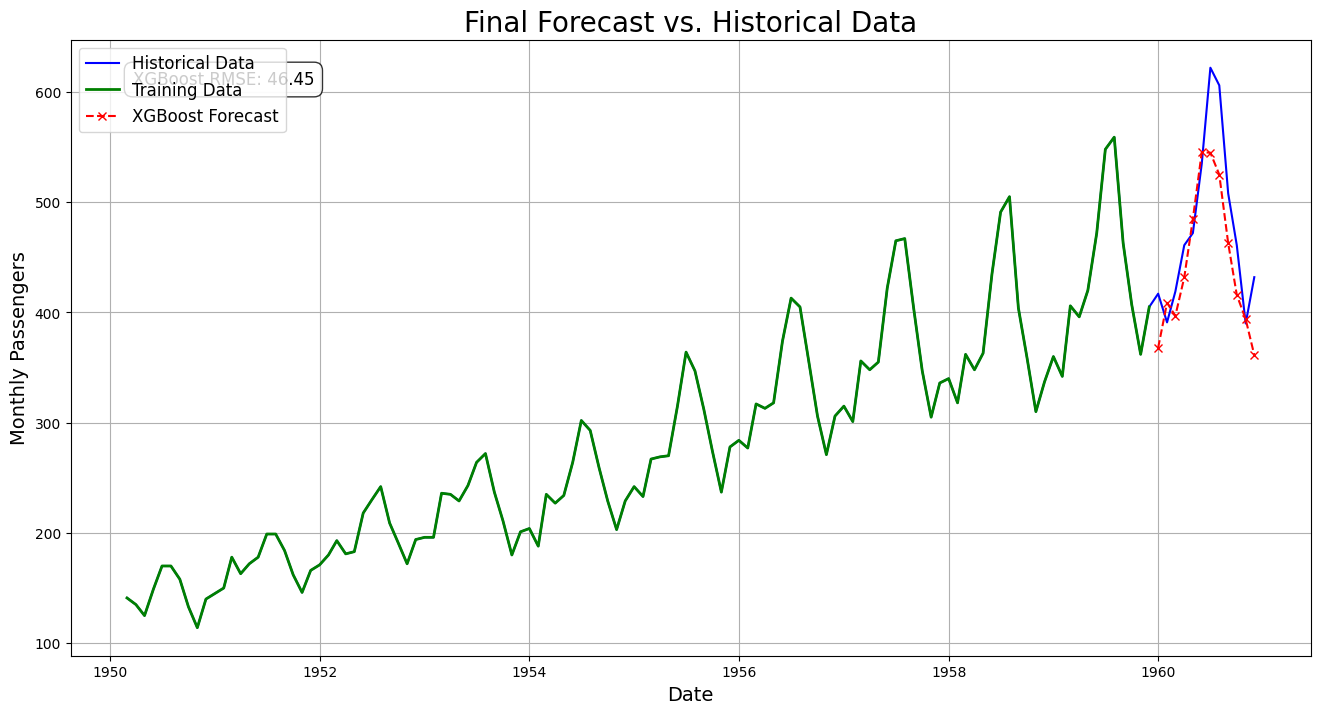

In [18]:
# Create a new cell and run this code after your XGBoost training

# --- 1. Combine training data and forecast ---
combined_df = pd.concat([y_train, y_test])
combined_df = combined_df.rename('Actuals')
combined_df = combined_df.to_frame()
combined_df['Forecast'] = np.nan
combined_df['Forecast'].iloc[len(y_train):] = predictions

# --- 2. Create the final plot ---
plt.figure(figsize=(16, 8))
plt.plot(combined_df['Actuals'], label='Historical Data', color='blue')
plt.plot(y_train.index, y_train, label='Training Data', color='green', linewidth=2, linestyle='-')
plt.plot(y_test.index, combined_df['Forecast'][len(y_train):], label='XGBoost Forecast', color='red', linestyle='--', marker='x')

plt.title('Final Forecast vs. Historical Data', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Passengers', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Add a text box with the key metric
text_box = f"XGBoost RMSE: {np.round(46.45, 2)}"
plt.text(0.05, 0.95, text_box, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.show()